<a href="https://colab.research.google.com/github/YNWA-Algo/CompanyPolicyRAGChatbot/blob/main/CompanyPolicyRAGChatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
pip install wget torch numpy faiss-cpu transformers tokenizers

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 140.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 80.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8bd

In [2]:
!pip install wget torch numpy faiss-cpu transformers tokenizers

In [3]:
!pip install --user matplotlib scikit-learn

In [4]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Defining Helper Functions

In [5]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

# Load and Process Data

In this section of the workflow, the focus is to load and prep text data for the question-answering system.

In [6]:
#Download specific file text - read and preprocess to make and ensure suitability for NLP tasks

#use wget library to download text file containing the data (company policy) companyPolicies.txt

filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


In [7]:
# With file downloaded, need to Read and preprocess the file (data) - open, read and splitting into individual paragraphs, filtering out empty paragraphs. Each paragraph represents a section of the company policies

def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split the text into paragraphs (simple split by newline characters)
    paragraphs = text.split('\n')
    # Filter out any empty paragraphs or undesired entries
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

In [8]:
#look at the first few samples of the file
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )


sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



# Develop the Retriever
Clean , transform text to vector embeddings using DPR (data passage Retriever model); FAISS

In [9]:
# STEP 1: Tokenization
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [10]:
#Detour - using a simple sample text for ease in relating back to BERT
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


In [11]:
#view the token indexes

tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
#To translate these indices back into readable tokens, you can use the method convert_ids_to_tokens
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


In [13]:
#STEP 2: Encoding - feed tokenized text into the encoder - distill into a representation of the semantic essense of the text.
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
#shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

In [15]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.2918,  0.3407,  0.0421,  ..., -0.4343, -0.5157,  0.1139],
        [ 0.9915,  0.4669, -0.0584,  ..., -0.1972, -0.3929, -0.0108],
        [ 0.3005,  0.5121, -0.1546,  ..., -0.7096, -0.9071,  0.2282],
        ...,
        [ 0.6975,  0.5583,  0.1917,  ..., -0.6279, -0.4837, -0.1460],
        [ 0.3164, -0.2672,  0.0067,  ...,  0.1750, -0.3381,  0.4668],
        [ 0.6988,  0.3530, -0.2090,  ..., -0.1273, -0.3183, -0.4182]],
       grad_fn=<SliceBackward0>)

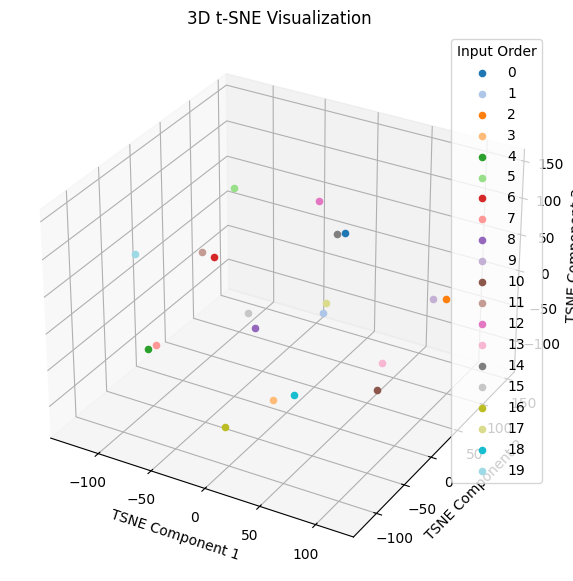

In [16]:
tsne_plot(outputs.pooler_output.detach().numpy())

Samples 16 and 12 are closer to each other on the graph shown above. Let's view the corresponding paragraphs:


In [17]:
print("sample 16:", paragraphs[16])

sample 16: Compliance: Ensure compliance with all relevant laws and regulations regarding internet and email usage, including those related to copyright and data protection.


In [18]:
print("sample 12:", paragraphs[12])

sample 12: Treatment and Assistance: Employees with substance abuse issues are encouraged to seek help. The organization is committed to providing support, resources, and information to assist those seeking treatment.


In [ ]:
# Step 3: Aggregation

In [19]:
#compile a list containing each sample, where each sample has specific dimensions

embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [20]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

In [21]:
#consolidate steps 1, 2, 3 into a funtion
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

# Creating and populating a FAISS index

After the text paragraphs are encoded into dense vector embedding, then need to create and populate FAISS indess to aid efficiency and scalability

In [ ]:
#Index type: IndexFlatL2 is one of the simplest and most used indexes in FAISS. It computes the Euclidean distance (L2 norm) between the query vector and the dataset vectors to determine similarity.

In [22]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of the embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

# DPR question encoder and tokenizer

In [ ]:
# load the DPRQuestionEncoder and DPRQuestionEncoderTokenizer for encoding questions:

In [23]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
#Use the system to process a specific query and retrieve the most relevant conexts from the indexed data. The output should consist of D and I

In [24]:
# Example question
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[72.76534  74.7162   84.38811  88.36439  90.287125]]
I: [[13 17 15 18 35]]


In [25]:
#print out top5 relevant contexts
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")


Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76534271240234

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71620178222656

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38810729980469

4: 9.	Discipline and Termination Policy
distance 88.36438751220703

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28712463378906



In [26]:
#Convert the above to a function
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

# Enhance Reponse Generation with LLM's
combination of GPT2 for generation and DPR for question encoding creates a robust framework for your natural language processing application, enabling it to deliver accurate and context-aware responses.

GPT2 (Bidirectional and Auto-Regresstive Transformers) - Seq2seq model

In [27]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [28]:
#input text
contexts= "What is a large language model?"

In [29]:
#tokenize the input text to prepare it for the model:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)


{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [30]:
#Leverage LLM to generate the text
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

In [31]:
#Deconde the generated token indexes back to text:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


# Comparing answer generation: With and Without DPR context

In [32]:
### Generated answers directly from questions - without addiotional context

def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)

    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [33]:
# Example without context
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


In [34]:
### Generating answers with DPR Context

def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [35]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[20 63 35 10 22]]


In [36]:
# The top paragraphs from the query context retrieval are:

top_contexts = [paragraphs[idx] for idx in I[0]]
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


In [37]:
# Assume `I[0]` contains indices of top contexts from the retrieval step
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta

# Tuning Generation Parameters in GPT2
Parameters max_length, min_length, length_penalty, and num_beams in the generate_answer function - influences the answers generated by GPT2 from given contexts. See this

In [38]:
def generate_answer(contexts, max_len=50, min_len=40, length_penalty=2.0, num_beams=4):
    # Concatenate the retrieved contexts to form the input to BAR
    input_text = ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(
        inputs['input_ids'],
        max_new_tokens=max_len,
        min_length=min_len,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Define the question
question = "what is mobile policy?"

# Retrieve relevant contexts
_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]]

# Test different generation settings
settings = [
    (50, 50, 1.0, 2),
    (120, 30, 2.0, 4),
    (100, 20, 2.5, 6)
]

# Generate and print answers for each setting
for setting in settings:
    answer = generate_answer(top_contexts, *setting)
    print(f"Settings: max_new_tokens={setting[0]}, min_length={setting[1]}, length_penalty={setting[2]}, num_beams={setting[3]}")
    print("Generated Answer:", answer)
    print("\n" + "="*80 + "\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=50, min_length=50, length_penalty=1.0, num_beams=2
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=120, min_length=30, length_penalty=2.0, num_beams=4
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best 